# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".

## 1. Data Pre-processing

Our data is in the form of grayscale (black and white) images of chest x-rays. To perform our classification task effectively, we need to perform some pre-processing of the data.

First, we load all the relevant libraries.

In [1]:
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

Point a variable to the path where the data resides. Note that to use the code below you will need to move the folders effusion/ and nofinding/ into one common folder. You can do something like this:

```
mkdir CXR_Data
move effusion CXR_Data
move nofinding CXR_Data
```

In [2]:
DATASET_PATH = './CXR_data/Train/'

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

Next, we read the "effusion" and "nofinding" images.

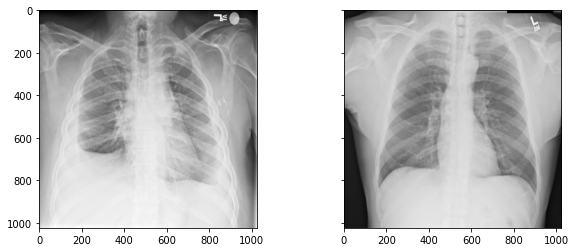

In [3]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [4]:
effusion.shape

(1024, 1024)

In [5]:
normal.shape

(1024, 1024)

### Data Augmentation ###

Now that we have read the images, the next step is data augmentation. We use the concept of a "data generator" that you learnt in the last section.

In [6]:
from skimage.transform import rescale
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant')
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

## 2. Model building

We will be using a Resnet in this (you learnt about Resnets previously). 

For this to work, the script that defines the resnet model (resnet.py) should reside in the same folder as this notebook

In [7]:
import resnet

img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

In [8]:
import numpy as np
import tensorflow as tf

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

## 3. Ablation Run

In the previous notebook, you learnt about Ablation. Briefly, an ablation run is when you systematically modify certain parts of the input, in order to observe the equivalent change in the input.

For the following section, we'll be using the Data Generator concept that you previously worked on.

In [9]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=validation_generator)

1/1 [==============================] - 0s 7ms/step - loss: 1.7904 - accuracy: 0.0968


In [10]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=5, validation_data=None)

Epoch 1/5
1/1 [==============================] - 0s 1ms/step - loss: 1.5446 - accuracy: 0.8710
Epoch 2/5
1/1 [==============================] - 0s 1ms/step - loss: 1.4087 - accuracy: 0.9062
Epoch 3/5
1/1 [==============================] - 0s 1ms/step - loss: 1.2696 - accuracy: 0.9688
Epoch 4/5
1/1 [==============================] - 0s 1ms/step - loss: 1.2622 - accuracy: 0.9355
Epoch 5/5
1/1 [==============================] - 0s 1ms/step - loss: 1.2330 - accuracy: 0.9355


In [11]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [12]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 1.4500 - accuracy: 0.7532
Val AUC for epoch0: 0.5660919540229885
5/5 [==============================] - 19s 4s/step - loss: 1.4500 - accuracy: 0.7532 - val_loss: 2.5576 - val_accuracy: 0.8750
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 1.2849 - accuracy: 0.9026
Val AUC for epoch1: 0.25287356321839083
5/5 [==============================] - 16s 3s/step - loss: 1.2849 - accuracy: 0.9026 - val_loss: 1.9678 - val_accuracy: 0.9062
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 1.2767 - accuracy: 0.9026
Val AUC for epoch2: 0.25287356321839083
5/5 [==============================] - 16s 3s/step - loss: 1.2767 - accuracy: 0.9026 - val_loss: 1.8519 - val_accuracy: 0.9062
Epoch 4/5
5/5 [==============================] - ETA: 0s - loss: 1.2693 - accuracy: 0.9026
Val AUC for epoch3: 0.4107142857142857
5/5 [==============================] - 16s 3s/step - loss: 1.2693 - accuracy: 0.9026 - val_loss: 

In [13]:
from functools import partial
import tensorflow.keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [14]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=None)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 1ms/step - loss: 2.3493 - accuracy: 0.7500


## 4. Final Run

After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [15]:
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [16]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy'])
# training_generator = AugmentedDataGenerator('train', ablation=50)
# validation_generator = AugmentedDataGenerator('val', ablation=50)

training_generator = AugmentedDataGenerator('train')
validation_generator = AugmentedDataGenerator('val')


auc_logger = roc_callback()
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

decay = DecayLR()



Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 2.2341 - accuracy: 0.5316
Val AUC for epoch0: 0.37055065409187704

Epoch 00001: val_loss improved from inf to 2.32673, saving model to models\best_model.hdf5
25/25 [==============================] - 98s 4s/step - loss: 2.2341 - accuracy: 0.5316 - val_loss: 2.3267 - val_accuracy: 0.1823
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 2.1752 - accuracy: 0.6080
Val AUC for epoch1: 0.4313953488372093

Epoch 00002: val_loss did not improve from 2.32673
25/25 [==============================] - 96s 4s/step - loss: 2.1752 - accuracy: 0.6080 - val_loss: 2.4920 - val_accuracy: 0.0990
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 2.0595 - accuracy: 0.6938
Val AUC for epoch2: 0.5281411621539398

Epoch 00003: val_loss did not improve from 2.32673
25/25 [==============================] - 95s 4s/step - loss: 2.0595 - accuracy: 0.6938 - val_loss: 2.3538 - val_accuracy: 0.1458
Epoch 4/10
25/25 

In [27]:
model.fit(training_generator, epochs=10, validation_data=validation_generator, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.9502 - accuracy: 0.7245
Val AUC for epoch0: 0.6644316730523627

Epoch 00001: val_loss did not improve from 2.13280
25/25 [==============================] - 97s 4s/step - loss: 1.9502 - accuracy: 0.7245 - val_loss: 2.4048 - val_accuracy: 0.8229
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.9640 - accuracy: 0.7102
Val AUC for epoch1: 0.6912077882567691

Epoch 00002: val_loss did not improve from 2.13280
25/25 [==============================] - 96s 4s/step - loss: 1.9640 - accuracy: 0.7102 - val_loss: 2.3600 - val_accuracy: 0.8594
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.8821 - accuracy: 0.7400
Val AUC for epoch2: 0.713720717979921

Epoch 00003: val_loss did not improve from 2.13280
25/25 [==============================] - 97s 4s/step - loss: 1.8821 - accuracy: 0.7400 - val_loss: 2.2703 - val_accuracy: 0.8073
Epoch 4/10
25/25 [==============================] - ETA: 0s

KeyboardInterrupt: 

## 5. Making a Prediction

In [28]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('models/best_model.hdf5')

In [43]:
gt_list = []
pred_list = []
effusion_path = os.path.join('./CXR_data/Test/', disease_cls[0], '*')
effusion = glob.glob(effusion_path)
for img_path in effusion:
    img = io.imread(img_path)
    #plt.imshow(img,cmap='gray')
    img = preprocess_img(img[:, :, np.newaxis], 'validation')
    gt_list.append(1)
    if val_model.predict(img[np.newaxis,:])[0][1] >= 0.5:        
        pred_list.append(1)
        print('correct')
    else:        
        pred_list.append(0)
        print('Incorrect')

Incorrect
Incorrect
correct
correct
correct
Incorrect
correct
correct
correct
correct


In [44]:
effusion_path = os.path.join('./CXR_data/Test/', disease_cls[1], '*')
effusion = glob.glob(effusion_path)
for img_path in effusion:
    try:
        img = io.imread(img_path)
        #plt.imshow(img,cmap='gray')
        img = preprocess_img(img[:, :, np.newaxis], 'validation')
        gt_list.append(0)
        if val_model.predict(img[np.newaxis,:])[0][0] >= 0.5:
            pred_list.append(0)
            print('correct')
        else:
            pred_list.append(1)
            print('Incorrect')
    except Exception as e:
        print(e)
        

Incorrect
correct
correct
correct
correct
Incorrect
Incorrect
Incorrect
Incorrect
correct
correct
Incorrect
correct
Incorrect
correct
correct
correct
correct
Incorrect
correct
correct
correct
correct
Incorrect
Incorrect
correct
correct
correct
correct
Incorrect
correct
Incorrect
correct
Incorrect
correct
correct
correct
correct
Incorrect
correct
correct
correct
correct
cannot convert float infinity to integer
correct
Incorrect
Incorrect
correct
Incorrect
Incorrect
Incorrect
correct
correct
Incorrect
correct
cannot convert float infinity to integer
correct
correct
Incorrect
correct
correct
Incorrect


In [51]:
from sklearn.metrics import classification_report,f1_score,confusion_matrix

In [48]:
print(classification_report(gt_list,pred_list))

              precision    recall  f1-score   support

           0       0.93      0.63      0.75        60
           1       0.24      0.70      0.36        10

    accuracy                           0.64        70
   macro avg       0.58      0.67      0.56        70
weighted avg       0.83      0.64      0.70        70



In [52]:
f1_score (gt_list,pred_list )#,confusion_matrix

0.358974358974359

In [53]:
confusion_matrix(gt_list,pred_list)

array([[38, 22],
       [ 3,  7]], dtype=int64)